In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from math import log, exp, sqrt, isnan
import pandas as pd

#### Here we define fits and variables

In [2]:
dt = .001 # Time differential

t0 =  0  # intial time
tF = 60  # final time

"""B0 → 71.5717, dBG → 0.065535, deltaB → 0.226845, deltaG → 0.104574,
deltaM → 0.0817739, deltaP → 0.107014, dG → 0.179527, fM → 7.04933, hB → 0.000108336,
hG → 2.34565 × 10-11, lambda → 5.37004, lambdaG → 2.13042, m → 1.80624,
muG → 1.2265 × 107, rB → 6.16541, rG → 0.262815, sigmaA → 0.135469, sigmaN → 0.409708"""

# Constants/fits emaileld
B01 = 72.559
d_BG1 = 0.0635991
delta_B1 = 0.236724
delta_G1 = 0.0982312
delta_M1 = 0.205638
delta_P1 = 0.151396
d_G1 = 0.322589
d_M1 = d_G1 #0.00245009 
d_P1 = d_G1 #0.0161013  
#f_M1 = .5 
f_M1 = 11.0984         # why is f_M this high? it's a probability, so shouldn't it be <= 1?
h_B1 = 0.0000941496
h_G1 = 1.68872*(10**-11)
lam1 = 5.33041
lam_g1 = 2.13481
m1 = 1.82175
mu1 = 1.2274*(10**7)
r_B1 = 6.13599
r_G1 = 0.274329

# Contstants/fits from Mathematica code
B02 = 71.5717
d_BG2 = 0.065535
delta_B2 = 0.226845
delta_G2 = 0.104574
delta_M2 = 0.0817739
delta_P2 = 0.107014
d_G2 = 0.179527
f_M2 = 7.04933

h_B2 = 0.000108336
h_G2 = 2.34565 * (10 ** -11)
lam2 = 5.37004
lam_g2 = 2.13042
m2 = 1.80624
mu2 = 1.2265 * (10 ** 7)
r_B2 = 6.16541
r_G2 = 0.262815

sigma_A2 = 0.135469;
sigma_N2 = 0.409708;


             # 0    1      2         3         4         5         6     7     8     9     10    11      12  13   14    15    16    17    18        19
vInit = tuple((B02, d_BG2, delta_B2, delta_G2, delta_M2, delta_P2, d_G2, f_M2, h_B2, h_G2, lam2, lam_g2, m2, mu2, 0.0000000001, 0.0000000001, r_B2, r_G2, sigma_A2, sigma_N2))
vNames = tuple(("B0", "d_BG", "delta_B", "delta_G", "delta_M", "delta_P", "d_G", "f_M", "h_B", "h_G", "lam", "lam_g", "m", "mu", "r_AB", "r_AG", "r_B", "r_G", "sigma_A", "sigma_N"))

"""
using dA/dt = -lam * A * B - m * A, got NLL of +15 with 
v = (71.9036345134219, 1.918630079935582, 0.007049512908650367, 0.004613922315413071, 0.05450452479991991, 0.07312112415119541, 0.14012765648218137, 7.014468289686113, 1.5991759040332608e-06, 2.0826474272794448e-150, 5.131474989172205, 0.00019283400578255653, 1.9617384505792512, 12265000.0000001, 6.412025790720321, 0.13437930131875972, 0.2594629166514494, 1.795280573431003)
this is a terrible fit so don't do it like this at all
"""
"""
using dA/dt = -(lam + m)A - r_B * B got NLL of -35,
but also sucks and just variance-hacked its way in. model looks terrible
v = (72.07226432667244, 3.8181016851300607, 0.013669295032403522, 0.07580649532064503, 0.05980678793281995, 0.02992757994580501, 0.654528871250306, 6.9795691534654045, 1.4900920031134332e-06, 2.1076848248349705e-150, 5.027013531829537, 0.00019283400578255563, 1.915591996134985, 12265000.0000001, 3.189368275664023, 0.201515705930629, 0.22635798845851215, 1.71223143886827)::w:
"""
"""
having a seperate rate for absorbtion of antigens than proliferation of B/G
i.e. dA/dt = -(lam + m) * A - r_AB * B
where r_AB is the rate of abosorbtion of antigens by plasmablasts
also does not work, got nLL of -16
"""

"""
best NLL of +36
v = tuple(v =  (72.20777261000725, 0.668307421358547, 0.943462722833185, 0.15116007920713576, 0.04013717454699595, 0.0021197560657581025, 0.4871358556172287, 6.877372181317135, 0.00011467971438362333, 2.3379532209302554e-20, 5.36956765456493, 1.5674515141941416, 1.8062761754671086, 12265000.0, 6.125710507491463, 7.735448110373098e-06, 1.3391474976252657, 0.18720929765866007, 0.23089710016537554, 1.904750049103381))
"""

# v with miniscule r_AB and r_AG works best, implying they might not should be here:w

#v =  tuple((71.5717, 0.065535, 0.226845, 0.104574, 0.0817739, 0.107014, 0.179527, 7.04933, 0.000108336, 2.3456499999999998e-11, 5.369792134123187, 2.1311447811212085, 1.8061249556639605, 12265000.0, 3.4085702236284584e-11, 1.1388935818034943e-06, 6.16541, 0.262815, 0.135469, 0.409708))

# -148 for NLL, but r_AB is essentially 0.0. maybe r_AG actually plays a role tho. 
# this could also just be aresult of it just being able to do better w/ more parameters
# graphs look identical
# most variables only differ slighly from other model, 
# with the exception of the sigma's which have changed a fair bit.
v = tuple((71.57472179585143, 0.06806791688388425, 0.2271995896057752, 0.0970778060641627, 0.07646007599820213, 0.10381404112401264, 0.18115586481910223, 7.049406226094551, 0.000108336, 2.3456499999999998e-11, 5.3523856961122505, 2.1319481641138216, 1.8002360194780402, 12265000.0, 1.0942497116353911e-33, 2.6169144847532832e-06, 6.18710405594742, 0.2521578548249285, 0.1972155867693602, 0.46150093515254786))

# Sets if r_Gk is constant or if r_Gk = r_G*sqrt(k)
variabler_G = True

# Intial conditions
A0 = 1
A_g0 = 0

# the number of steps
N = int(round((tF-t0)/dt))

Aarr = np.zeros(N + 1)
Aarr[0] = A0
A_garr = np.zeros(N + 1)
A_garr[0] = A_g0
Barr = np.zeros(N + 1)
Barr[0] = vInit[0]

Garr = np.zeros((4, N + 1))
Marr = np.zeros((4, N + 1))
Parr = np.zeros((4, N + 1))

Gtotarr = np.zeros(N + 1)
Mtotarr = np.zeros(N + 1)
Ptotarr = np.zeros(N + 1)

tarr = np.zeros(N + 1)
tarr[0] = t0


#### Here we set up the arrrays for approximating the model

In [3]:
def reInitArrs(B0):
    global Aarr, A_garr, Barr, Garr, Marr, Parr, Gtotarr, Mtotarr, Ptotarr, tarr
    
    Aarr = np.zeros(N + 1)
    Aarr[0] = A0
    A_garr = np.zeros(N + 1)
    A_garr[0] = A_g0
    Barr = np.zeros(N + 1)
    Barr[0] = B0

    Garr = np.zeros((4, N + 1))
    Marr = np.zeros((4, N + 1))
    Parr = np.zeros((4, N + 1))

    Gtotarr = np.zeros(N + 1)
    Mtotarr = np.zeros(N + 1)
    Ptotarr = np.zeros(N + 1)

    tarr = np.zeros(N + 1)
    tarr[0] = t0


#### Here we have all the equations for the affinity model as laid out in the writeup

In [4]:
#Eqn 1
def dAdt(lam, m, r_AB, A, B):
    return - lam * A - m * A - r_AB * B * A

#Eqn 2
def dA_gdt(lam_g, m, r_AG, A, A_g, G):
    return m * A - lam_g * A_g  - r_AG * A_g * G

#Eqn 3
def dBdt(r_B, h_B, delta_B, d_BG, A, B):
    return r_B * A / (h_B + A) * B - (delta_B + d_BG) * B

    #Eqn 4 and 5
# k is the index on G
#G[k]'[t] == If[k == 1, 1, 0] * dBG * B[t] + (1 - muG / (1 + muG) * If[k == nA, 0, 1]) * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) * G[k][t] - (deltaG + dG * rG * Sqrt[k] * Ag[t] / (hG + Ag[t])) * G[k][t] + muG / (1 + muG) * 
           # If[k == 1, 0, 1] * rG * Sqrt[k - 1] * Ag[t] / (hG + Ag[t]) * G[k - 1][t], {k, 1, nA}],            
def dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1):
    if(k == 1): c0 = 1
    else: c0 = 0
        
    # modifiy n here
    if(k == 3): c1 = 0
    else: c1 = 1
        
    if(k == 1): c2 = 0
    else: c2 = 1
    
    return c0 * d_BG * B + (1 - mu / (1 + mu) * c1) * r_G * math.sqrt(k) * A_g / (h_G + A_g) * G_k - (delta_G + d_G * r_G * math.sqrt(k) * A_g / (h_G + A_g)) * G_k + mu / (1 + mu) * c2 * r_G * math.sqrt(k-1) * A_g / (h_G + A_g) * G_kmin1
    
#Eqn 6
# fM * Exp[-aM * (k - 1)] / (1 + fM * Exp[-aM * (k - 1)]) * dG *G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaM * M[k][t],
def dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k):
    a_M = .5 # ???? or is it fit?
    return f_M * math.exp(-1 * a_M * (k - 1)) / (1 + f_M * math.exp(-1 * a_M * (k - 1))) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_M * M_k

#Eqn 7
#Table[P[k]'[t] == (1 / (1 + fM * Exp[-aM * (k - 1)])) * dG * G[k][t] * rG * Sqrt[k] * Ag[t] / (hG + Ag[t]) - deltaP * P[k][t], {k, 1, nA}]
def dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k):
    a_M = .5 
    return (1 / (1 + f_M * math.exp(-a_M * (k - 1)) ) ) * d_G * G_k * r_G * math.sqrt(k) * A_g / (h_G + A_g) - delta_P * P_k


#### The main function of the model. 
It utilizes the Euler method for approximating systems of differential equations:
https://en.wikipedia.org/wiki/Euler_method
There may be limitations (esp w/ small time steps) when using this method

In [5]:
# Euler method
def euler(v):
    global Aarr, A_garr, Barr, tarr, Garr, Parr, Marr, Gtotarr, Mtotarr, Ptotarr
    
    (B0, d_BG, delta_B, delta_G, delta_M, delta_P, d_G, f_M, h_B, h_G, lam, lam_g, m, mu, r_AB, r_AG, r_B, r_G, sigma_A, sigma_N) = v
    reInitArrs(B0)
    
    for i in range(1, N + 1):
        #f_M = .5
        A = Aarr[i - 1]
        A_g = A_garr[i - 1]
        B = Barr[i - 1]
        G = Gtotarr[i - 1]
        t = tarr[i - 1]
        Aarr[i] = A + dt * dAdt(lam, m, r_AB, A, B)
        A_garr[i] = A_g + dt * dA_gdt(lam_g, m, r_AG, A, A_g, G)
        Barr[i] = B + dt * dBdt(r_B, h_B, delta_B, d_BG, A, B)
    
        for k in range(1, 4):
            G_k = Garr[k, i - 1]
            G_kmin1 = Garr[k - 1, i - 1]
            P_k = Parr[k, i - 1]
            M_k = Marr[k, i - 1]
            Garr[k, i] = G_k + dt * dG_kdt(k, d_BG, d_G, h_G, delta_G, mu, r_G, A_g, B, G_k, G_kmin1)
            Marr[k, i] = M_k + dt * dM_kdt(k, f_M, d_G, r_G, h_G, delta_M, A_g, G_k, M_k)
            Parr[k, i] = P_k + dt * dP_kdt(k, f_M, d_G, r_G, h_G, delta_P, A_g, G_k, P_k)

            Gtotarr[i] += Garr[k, i]
            Ptotarr[i] += Parr[k, i]
            Mtotarr[i] += Marr[k, i]
            
    
        tarr[i] = t + dt
    
    for i in range(1, len(Barr)):
        Barr[i]+= B0

#### Here, we extract expiremental data from csv's to plot w/ model

In [6]:
# Cell counts for  PBs GCBs and MCs
csv = pd.read_csv('data-Bcell-dynamics-edited-permouse.csv', index_col = 'day', names=['day','PB','GC','MC'])
Stimes = csv.index.values[1:-1].astype('int')
Spb = csv.PB.values[1:-1].astype('double')
Sgc = csv.GC.values[1:-1].astype('double')
Smc = csv.MC.values[1:-1].astype('double')

# Cell counts for PC's
xlsx = pd.read_excel('LLPC_total_numbers.xlsx', index_col = 'day', names =['day','zero','one','two','three'])
Stimes2 = xlsx.index.values[0:4].astype('int')
Stimes2 = np.repeat(Stimes2, 4)
Spc = np.zeros(16)
for i in range (0, 4):
    Spc[4*i + 0] = xlsx.zero.values[i].astype('double')
    Spc[4*i + 1] = xlsx.one.values[i].astype('double')
    Spc[4*i + 2] = xlsx.two.values[i].astype('double')
    Spc[4*i + 3] = xlsx.three.values[i].astype('double')

# Cell affinities
csv2 = pd.read_csv('data-IgHg2A10_affinity-cleaned.csv', index_col = 'day', names = ['day', 'AA', 'celltype', 'mouse'])
csv2.sort_values(by = 'day')
Sapbt, Sagct, Samct, Sapct = [], [], [], []
Sapb, Sagc, Samc, Sapc = [], [], [], []

for i in range(len(csv2.index)):
    if(csv2.celltype.values[i] == "PB"):
        Sapbt.append(int(csv2.index.values[i]))
        Sapb.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "GC"):
        Sagct.append(int(csv2.index.values[i]))
        Sagc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "MC" or csv2.celltype.values[i] == "MBC"):
        Samct.append(int(csv2.index.values[i]))
        Samc.append(float(csv2.AA.values[i]))
    if(csv2.celltype.values[i] == "PC"):
        Sapct.append(int(csv2.index.values[i]))
        Sapc.append(float(csv2.AA.values[i]))

In [7]:
def calcAA():
    global Garr, Gtotarr, Marr, Mtotarr, Parr, Ptotarr, Barr
    
    BAarr, GAarr, MAarr, PAarr = np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1)), np.zeros((N + 1))
    avgPBA = 0
    k = 0
    for i in Sapb:
        if(math.isnan(i)):
            continue
        avgPBA += i
        k += 1
    avgPBA = avgPBA / k
    
    for i in range(N+1):
        
        avgG, avgM, avgP = 0, 0, 0
        for j in range(1, 4):
            avgG += Garr[j, i] * j
            avgM += Marr[j, i] * j
            avgP += Parr[j, i] * j
            
        totG = Gtotarr[i]
        totM = Mtotarr[i]
        totP = Ptotarr[i]
        if(totG == 0): totG = 1
        if(totM == 0): totM = 1
        if(totP == 0): totP = 1
        avgG = avgG/totG
        avgM = avgM/totM
        avgP = avgP/totP 
    
        BAarr[i] = avgPBA 
        GAarr[i] = avgG
        MAarr[i] = avgM
        PAarr[i] = avgP
        
    return [BAarr, GAarr, MAarr, PAarr]


In [8]:
def NLL(v):
    
    euler(v)
    
    # Scatter number, model number of cells
    snt = [Stimes, Stimes, Stimes, Stimes2]
    sn = [Spb, Sgc, Smc, Spc]
    mn = [Barr, Gtotarr, Mtotarr, Ptotarr]
    
    sat = [Sapbt, Sagct, Samct, Sapct]
    sa = [Sapb, Sagc, Samc, Sapc]
    ma = calcAA()
    
    sum1 = 0
    n1 = 0
    for j in range(4):
        k = 0
        for i in snt[j]:
            actual = sn[j][k]
            predicted = mn[j][int(i/dt)]
            k += 1
            if(actual <= 0 or predicted <= 0 or math.isnan(actual)): continue
            n1 += 1
            sum1 += ( (math.log(actual, 10) - math.log(predicted, 10)) ** 2 ) / (2 * (v[-1] ** 2))
            #print(j, i, actual, predicted, sum1)
    
    sum2 = 0       
    n2 = 0
    for j in range(4):
        k = 0
        for i in sat[j]:
            actual = sa[j][k]
            predicted = ma[j][int(i/dt)]
            k += 1
            if(math.isnan(actual)): continue
            n2 += 1
            sum2 += ((actual- predicted) ** 2) / (2 * (v[-2] ** 2))
            #print(j, i, actual, predicted, sum2)
        
    #n1 = len(Stimes)
    #n2 = len(Sapbt) # This does make it so that we are using n1/n2 unrelated to what we have summed over
    
    
    #print(sum1)
    #print(sum2)
        
    # Also, the base for logs just changes here for no reason????
    return (sum1 + sum2 + (n1 * math.log(v[-1])) + (n2 * math.log(v[-2])))

print(NLL(vInit))

-76.34312711996864


#### Here, we run the model and graph the results

(71.57472452847854, 0.06807084073142161, 0.22720626883744185, 0.09706685514369122, 0.0764520033537888, 0.10380868323158918, 0.1811564425910233, 7.049408265245472, 0.000108336, 2.3456499999999998e-11, 5.352382461306332, 2.1319420822685786, 1.8002352189114743, 12265000.0, 1.09904934103003e-33, 2.3552230362779548e-06, 6.187118410563263, 0.2521616013386584, 0.1972919392899808, 0.4616129584320658)
-148.39293711875723


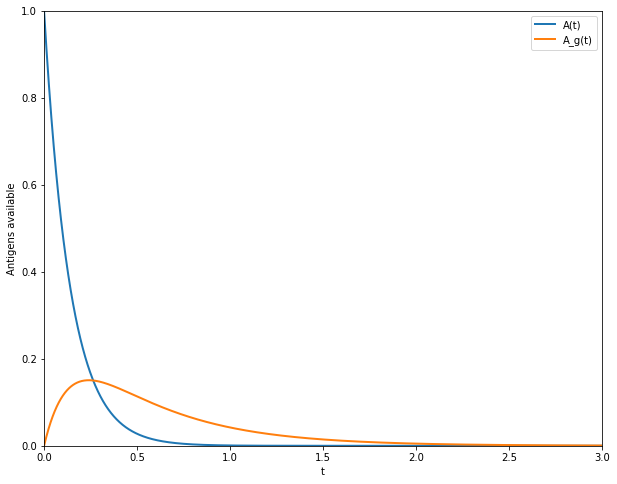

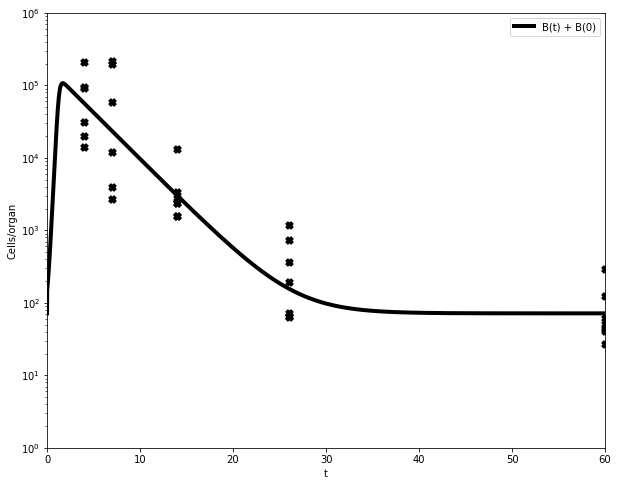

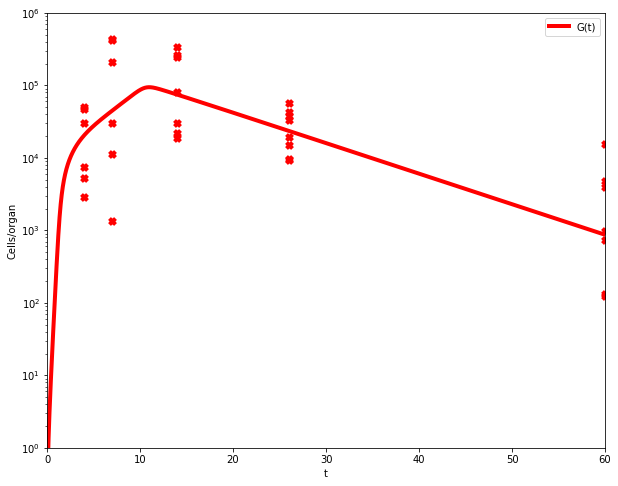

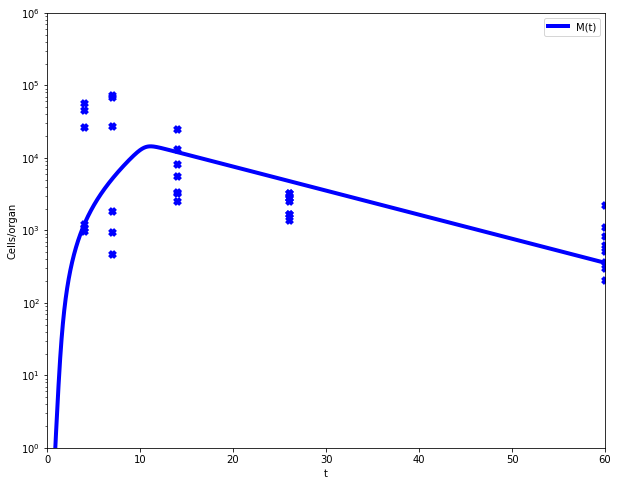

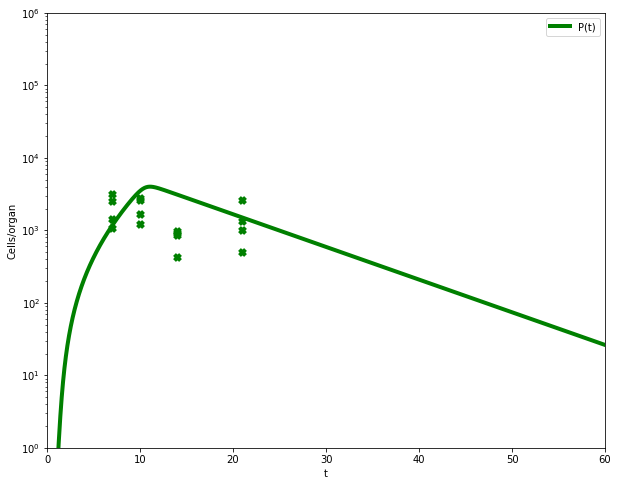

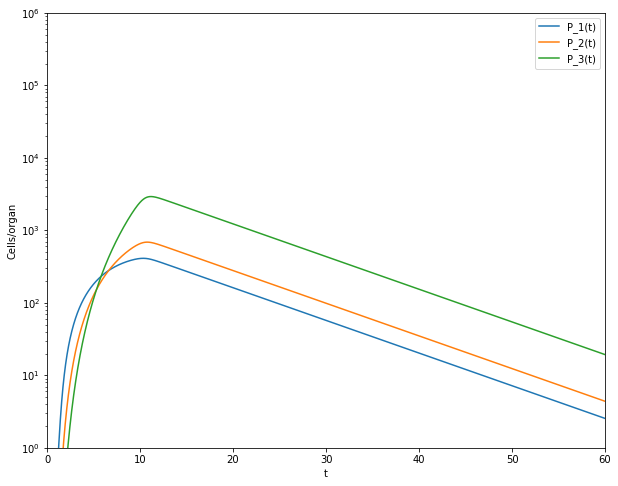

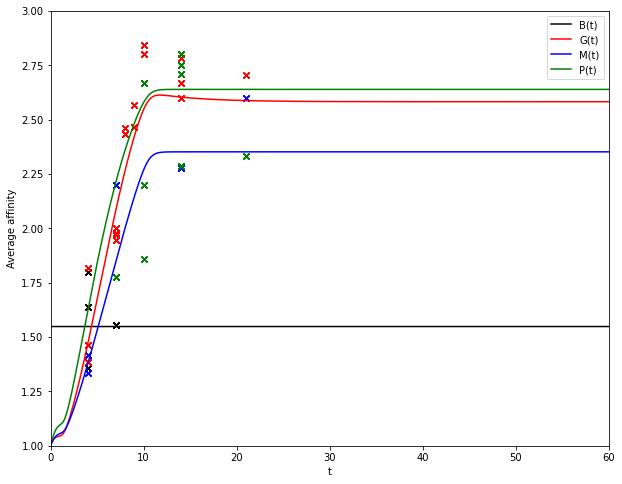

In [16]:
# Call the function to run the model so we can graph

# here are the variables w/ the lowest SSR i got with gradient descent. SSR: 5.148666e+11
# (71.59205434857685, 0.06806932130591119, 0.2104126492314999, 0.09116913023495661, 0.08178938340112435, 0.10701968476189978, 0.17310394397234516, 7.049336642090847, 7.10792496e-05, 1.8724084774374178e-11, 5.252497501199031, 2.1041403856757808, 1.7679069783484835, 12265000.0, 6.313904193296472, 0.19885356550859085, 0.135469, 0.409708)

print(v)
print(NLL(v))

# Graph of antigens available
fig1 = plt.figure()
fig1.set_size_inches(10,8)

plt.plot(tarr, Aarr, label = "A(t)", linewidth = 2)
plt.plot(tarr, A_garr, label = "A_g(t)", linewidth = 2)

plt.xlabel("t")
plt.ylabel("Antigens available")

plt.axis([t0, 3, 0, 1])

plt.legend()
plt.show()

#Plasmablasts graph

fig2 = plt.figure()
fig2.set_size_inches(10,8)

plt.plot(tarr, Barr, linewidth = 4, label = "B(t) + B(0)", color = 'black')
plt.scatter(Stimes, Spb, linewidth = 4, marker = 'x', color = 'black')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# GC B cells graph

fig3 = plt.figure()
fig3.set_size_inches(10,8)

plt.plot(tarr, Gtotarr, linewidth = 4, label = "G(t)", color = 'red')
plt.scatter(Stimes, Sgc, linewidth = 4, marker = 'x', color = 'red')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# MCB cells graph

fig4 = plt.figure()
fig4.set_size_inches(10,8)

plt.plot(tarr, Mtotarr, linewidth = 4, label = "M(t)", color = 'blue')
plt.scatter(Stimes, Smc, linewidth = 4, marker = 'x', color = 'blue')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Plasma cells graph

fig5 = plt.figure()
fig5.set_size_inches(10,8)

plt.plot(tarr, Ptotarr, linewidth = 4, label = "P(t)", color = 'green')
plt.scatter(Stimes2, Spc, linewidth = 4, marker = 'x', color = 'green')

plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.xscale("linear")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show()

# Graph of GC B cell affinities 

fig6 = plt.figure()
fig6.set_size_inches(10,8)


plt.plot(tarr, Parr[1], label = "P_1(t)")
plt.plot(tarr, Parr[2], label = "P_2(t)")
plt.plot(tarr, Parr[3], label = "P_3(t)")
plt.xlabel("t")
plt.ylabel("Cells/organ")
plt.yscale("log")
plt.axis([t0, tF, 1, 10**6])

plt.legend()
plt.show

# Average affinities
fig7 = plt.figure()
fig7.set_size_inches(10,8)

plt.plot(tarr, calcAA()[0], label = "B(t)", color = 'black')
plt.scatter(Sapbt, Sapb, marker = 'x', color = 'black')
plt.plot(tarr, calcAA()[1], label = "G(t)", color = 'red')
plt.scatter(Sagct, Sagc, marker = 'x', color = 'red')
plt.plot(tarr, calcAA()[2], label = "M(t)", color = 'blue')
plt.scatter(Samct, Samc, marker = 'x', color = 'blue')
plt.plot(tarr, calcAA()[3], label = "P(t)", color = 'green')
plt.scatter(Sapct, Sapc, marker = 'x', color = 'green')


plt.xlabel("t")
plt.ylabel("Average affinity")
plt.axis([t0, tF, 1.0, 3.0])

plt.legend()
plt.show()

#### Here, we start fitting variables to the data using gradient descent

It is currently set to use SSR for this. This does not seem to be a good function to use for fitting the graph, as fits with less SSR don't look as good as the init fit.

In [15]:
learningRate = .1

def grad(v):
    nll1 = NLL(v)
    
    nlllist.append(nll1)
    print(nll1)
    
    grad = tuple(())
    
    for i in range(0, len(v)):
        if(vNames[i] in ["h_G", "h_B"]):
            grad += tuple((0.0,))
            continue
        
        dV = .00000001
        v2 = v[0:i] + tuple((v[i] + dV, )) + v[i+1:]
        dnll = NLL(v2) - nll1
    
        print('  dV of ', dV, ' on ', vNames[i], ' got nll of', dnll + nll1, ' for a dnll ', dnll)
        
        if(isnan(dnll)):
            grad += tuple((0.0,))
            continue
        
        grad += tuple((dnll/dV, ))
    
    print('  grad =', grad)
    
    return grad
    
def deltaV(grad, v):
    gMax = max(np.absolute(grad))
    gMin = min(np.absolute(grad))
        
    deltaV = tuple(())
    for i in range(0, len(v)):
        if (grad[i] == 0.0): deltaV += tuple((0.0,))
        else: deltaV += tuple(((-1 * (grad[i]/abs(grad[i])) * (abs(grad[i]/gMax))* v[i] * learningRate),))
    
    return deltaV
        
              
def gradDescent(v):
    strikes = 0 # just like baseball, if it misses 3 times we stop
    for i in range (1, 100):
        nllOld = NLL(v)
        
        print(i)
        print('v = ', v)
        
        dV = deltaV(grad(v), v)
        print('dV = ', dV)
        
        newV = tuple(())
        
        for j in range(0, len(v)):
            newV += tuple((v[j] + dV[j], ))
        
        nllNew = NLL(newV)
        
        if(nllNew > nllOld): 
            if(strikes == 0): goodV = v
            strikes += 1
            if(strikes >= 3):
                return goodV
            
        else: 
            strikes = 0
        
        v = newV
            
    
    return v

nlllist = list((NLL(v),))
v = gradDescent(v)

print(nlllist)

1
v =  (71.57401587453491, 0.06734344503848821, 0.22620957181837342, 0.09945912386764724, 0.07818371999477124, 0.1048836522540956, 0.1809080007117675, 7.049122623273815, 0.000108336, 2.3456499999999998e-11, 5.354368030471935, 2.1319194703370927, 1.800901984919894, 12265000.0, 5.231220002383316e-32, 2.055126345896988e-06, 6.182700394647712, 0.2526888200668607, 0.1792767514098623, 0.4398925777829572)
-138.42121334027223
  dV of  1e-08  on  B0  got nll of -138.42121334081395  for a dnll  -5.417177817435004e-10
  dV of  1e-08  on  d_BG  got nll of -138.4212139029621  for a dnll  -5.626898769151012e-07
  dV of  1e-08  on  delta_B  got nll of -138.42121345828485  for a dnll  -1.1801262189692352e-07
  dV of  1e-08  on  delta_G  got nll of -138.42121221037826  for a dnll  1.1298939739390335e-06
  dV of  1e-08  on  delta_M  got nll of -138.4212123502856  for a dnll  9.899866313389794e-07
  dV of  1e-08  on  delta_P  got nll of -138.42121291661363  for a dnll  4.2365860508652986e-07
  dV of  1e-

4
v =  (71.57404717926099, 0.06737408414967591, 0.22623154465748954, 0.0993681014146148, 0.07812096883720052, 0.1048475918832496, 0.18092004918661447, 7.049128157197753, 0.000108336, 2.3456499999999998e-11, 5.354246022297078, 2.1319196728521717, 1.8008609982028911, 12265000.0, 3.813559381737437e-32, 2.0695046021013913e-06, 6.182915028030532, 0.2526587877236555, 0.17995334545489644, 0.44057192601314804)
-138.8827142466685
  dV of  1e-08  on  B0  got nll of -138.88271424719323  for a dnll  -5.247215995041188e-10
  dV of  1e-08  on  d_BG  got nll of -138.8827147942851  for a dnll  -5.47616593848943e-07
  dV of  1e-08  on  delta_B  got nll of -138.8827143678114  for a dnll  -1.211428752867505e-07
  dV of  1e-08  on  delta_G  got nll of -138.8827131396526  for a dnll  1.1070159189330298e-06
  dV of  1e-08  on  delta_M  got nll of -138.88271327393272  for a dnll  9.727357905831013e-07
  dV of  1e-08  on  delta_P  got nll of -138.88271382924398  for a dnll  4.174245304966462e-07
  dV of  1e-0

7
v =  (71.57407929903377, 0.06740569033299969, 0.22625545023374535, 0.09927368914072938, 0.07805567935325741, 0.10480994588653757, 0.1809323349663997, 7.049134256009597, 0.000108336, 2.3456499999999998e-11, 5.354122791999057, 2.131920075402855, 1.800819595059079, 12265000.0, 2.7800847892865917e-32, 2.0916171870408336e-06, 6.183134285396861, 0.25262880861357645, 0.18065540178341583, 0.4412861392501417)
-139.35340401115135
  dV of  1e-08  on  B0  got nll of -139.35340401166061  for a dnll  -5.09260189573979e-10
  dV of  1e-08  on  d_BG  got nll of -139.3534045455014  for a dnll  -5.343500504295662e-07
  dV of  1e-08  on  delta_B  got nll of -139.3534041357986  for a dnll  -1.2464724363780988e-07
  dV of  1e-08  on  delta_G  got nll of -139.3534029238363  for a dnll  1.0873150415591226e-06
  dV of  1e-08  on  delta_M  got nll of -139.35340305421036  for a dnll  9.56940994001343e-07
  dV of  1e-08  on  delta_P  got nll of -139.35340360006873  for a dnll  4.1108262394118356e-07
  dV of  1e

10
v =  (71.5741123721918, 0.06743843268749922, 0.22628155179293435, 0.09917538296820078, 0.07798761330074813, 0.10477066273533997, 0.18094477187324393, 7.049140999933463, 0.000108336, 2.3456499999999998e-11, 5.353998017859325, 2.1319179139610727, 1.800777791601787, 12265000.0, 2.026681811389925e-32, 2.0238878490344273e-06, 6.18335892077646, 0.2526013172698282, 0.1813832486452877, 0.4420365971293092)
-139.83079952354927
  dV of  1e-08  on  B0  got nll of -139.83079952401886  for a dnll  -4.69583483209135e-10
  dV of  1e-08  on  d_BG  got nll of -139.83080001400128  for a dnll  -4.904520096715714e-07
  dV of  1e-08  on  delta_B  got nll of -139.83079964653245  for a dnll  -1.2298318097236915e-07
  dV of  1e-08  on  delta_G  got nll of -139.83079850844035  for a dnll  1.0151089213650266e-06
  dV of  1e-08  on  delta_M  got nll of -139.83079860938608  for a dnll  9.141631949205475e-07
  dV of  1e-08  on  delta_P  got nll of -139.83079911907026  for a dnll  4.0447901028528577e-07
  dV of  

13
v =  (71.57413196029124, 0.06745783967133658, 0.22629792372469248, 0.09911651620815426, 0.07794636198807689, 0.10474648467455681, 0.18095242847202864, 7.049145271927595, 0.000108336, 2.3456499999999998e-11, 5.353925722963022, 2.1319237377940525, 1.800753255997962, 12265000.0, 1.6962241557743137e-32, 2.204013867598491e-06, 6.183491129517479, 0.25257910586333693, 0.18182835224640262, 0.4425016734142283)
-140.11972485820772
  dV of  1e-08  on  B0  got nll of -140.11972485871033  for a dnll  -5.026095095672645e-10
  dV of  1e-08  on  d_BG  got nll of -140.11972539458654  for a dnll  -5.363788204704178e-07
  dV of  1e-08  on  delta_B  got nll of -140.1197249928331  for a dnll  -1.3462539527608897e-07
  dV of  1e-08  on  delta_G  got nll of -140.11972376148375  for a dnll  1.0967239632009296e-06
  dV of  1e-08  on  delta_M  got nll of -140.119723905774  for a dnll  9.524337087896129e-07
  dV of  1e-08  on  delta_P  got nll of -140.11972445732314  for a dnll  4.0088457353704143e-07
  dV of

16
v =  (71.57415500598667, 0.06748089625059724, 0.2263177879982658, 0.09904674524716318, 0.07789804967282653, 0.10471862764857728, 0.18096078812354655, 7.04915049061875, 0.000108336, 2.3456499999999998e-11, 5.353841074438459, 2.1319174480501437, 1.80072511746262, 12265000.0, 1.3794002746772852e-32, 1.963776356030255e-06, 6.1836464275593315, 0.25256535970011734, 0.18233914480738775, 0.44303925805890226)
-140.44182519533024
  dV of  1e-08  on  B0  got nll of -140.4418251957557  for a dnll  -4.25472990173148e-10
  dV of  1e-08  on  d_BG  got nll of -140.44182563765565  for a dnll  -4.423254154062306e-07
  dV of  1e-08  on  delta_B  got nll of -140.44182531785435  for a dnll  -1.2252411352164927e-07
  dV of  1e-08  on  delta_G  got nll of -140.44182425820452  for a dnll  9.371257192469784e-07
  dV of  1e-08  on  delta_M  got nll of -140.44182432869007  for a dnll  8.666401640766708e-07
  dV of  1e-08  on  delta_P  got nll of -140.44182479931283  for a dnll  3.960174126405036e-07
  dV of  

19
v =  (71.5741762903172, 0.06750209090740807, 0.2263370087244465, 0.0989818273754235, 0.07785225395254891, 0.10469155596120563, 0.1809691008471575, 7.049155585016837, 0.000108336, 2.3456499999999998e-11, 5.353764825383363, 2.131925765652717, 1.8006991456349037, 12265000.0, 1.1452452256842063e-32, 2.2378661783010407e-06, 6.183788772277617, 0.2525403023361184, 0.1828326556754412, 0.4435648018893306)
-140.7593915626661
  dV of  1e-08  on  B0  got nll of -140.75939156314809  for a dnll  -4.819753485207912e-10
  dV of  1e-08  on  d_BG  got nll of -140.7593920805685  for a dnll  -5.17902378760482e-07
  dV of  1e-08  on  delta_B  got nll of -140.75939170178248  for a dnll  -1.3911636642660596e-07
  dV of  1e-08  on  delta_G  got nll of -140.7593904932868  for a dnll  1.0693793228711002e-06
  dV of  1e-08  on  delta_M  got nll of -140.7593906321727  for a dnll  9.304933996645559e-07
  dV of  1e-08  on  delta_P  got nll of -140.75939117034875  for a dnll  3.923173608200159e-07
  dV of  1e-08 

22
v =  (71.57419650500933, 0.06752245259878993, 0.22635581741177027, 0.09891966226445345, 0.07780903588334087, 0.10466650903826466, 0.18097631796855726, 7.049160598101823, 0.000108336, 2.3456499999999998e-11, 5.353692675771035, 2.1319194885993467, 1.800675206355159, 12265000.0, 9.650143544853132e-33, 1.9939387648662272e-06, 6.183923802653536, 0.2525297204292283, 0.18328722192703467, 0.44405254982119785)
-141.03967052769733
  dV of  1e-08  on  B0  got nll of -141.03967052810404  for a dnll  -4.0671466194908135e-10
  dV of  1e-08  on  d_BG  got nll of -141.03967095316852  for a dnll  -4.254711996054539e-07
  dV of  1e-08  on  delta_B  got nll of -141.03967065426977  for a dnll  -1.2657244496949716e-07
  dV of  1e-08  on  delta_G  got nll of -141.0396696161418  for a dnll  9.115555315020174e-07
  dV of  1e-08  on  delta_M  got nll of -141.03966968186378  for a dnll  8.458335400973738e-07
  dV of  1e-08  on  delta_P  got nll of -141.03967013970546  for a dnll  3.879918608618027e-07
  dV o

25
v =  (71.57421617256816, 0.06754217417226996, 0.22637493006080658, 0.0988587239449919, 0.07776590346242059, 0.10464090206771635, 0.1809838785894343, 7.049165732160914, 0.000108336, 2.3456499999999998e-11, 5.353624242060124, 2.1319262008539535, 1.8006519333168778, 12265000.0, 8.195749189011483e-33, 2.2086025402147976e-06, 6.184054203473093, 0.25250815847478925, 0.18374943757666276, 0.44455379940632817)
-141.3317874535261
  dV of  1e-08  on  B0  got nll of -141.3317874539742  for a dnll  -4.480966708797496e-10
  dV of  1e-08  on  d_BG  got nll of -141.33178793597853  for a dnll  -4.824524353352899e-07
  dV of  1e-08  on  delta_B  got nll of -141.3317875929194  for a dnll  -1.3939330756329582e-07
  dV of  1e-08  on  delta_G  got nll of -141.33178644224924  for a dnll  1.0112768507042347e-06
  dV of  1e-08  on  delta_M  got nll of -141.33178656020397  for a dnll  8.933221238294209e-07
  dV of  1e-08  on  delta_P  got nll of -141.33178706894813  for a dnll  3.845779588118603e-07
  dV of 

28
v =  (71.5742446528415, 0.06757101964596432, 0.22640357198108724, 0.09876961414579037, 0.0777033261463789, 0.10460412908648889, 0.18099421295836152, 7.049173476168862, 0.000108336, 2.3456499999999998e-11, 5.353525873583494, 2.1319234287993827, 1.8006190387967094, 12265000.0, 6.493466668896252e-33, 2.0980507204518343e-06, 6.1842428567814425, 0.25248870936547246, 0.18440954238285504, 0.44527632930097516)
-141.73328089254375
  dV of  1e-08  on  B0  got nll of -141.73328089294574  for a dnll  -4.019966581836343e-10
  dV of  1e-08  on  d_BG  got nll of -141.7332813207056  for a dnll  -4.281618544155208e-07
  dV of  1e-08  on  delta_B  got nll of -141.73328102712964  for a dnll  -1.345858890999807e-07
  dV of  1e-08  on  delta_G  got nll of -141.73327997286788  for a dnll  9.196758696816687e-07
  dV of  1e-08  on  delta_M  got nll of -141.73328005159317  for a dnll  8.409505767303926e-07
  dV of  1e-08  on  delta_P  got nll of -141.7332805136328  for a dnll  3.7891095416853204e-07
  dV of

31
v =  (71.57426196197318, 0.06758852734293111, 0.22642194834184123, 0.09871486848034029, 0.07766435791855365, 0.10458081436313496, 0.18100078447118653, 7.049178486613113, 0.000108336, 2.3456499999999998e-11, 5.3534679297464445, 2.13192921985536, 1.8005993317566058, 12265000.0, 5.689960328663189e-33, 2.284777234572048e-06, 6.184356423543582, 0.2524704887367219, 0.18482500239626692, 0.44573715452215695)
-141.98283883867623
  dV of  1e-08  on  B0  got nll of -141.98283883911245  for a dnll  -4.362163963378407e-10
  dV of  1e-08  on  d_BG  got nll of -141.98283931388755  for a dnll  -4.7521132273686817e-07
  dV of  1e-08  on  delta_B  got nll of -141.9828389845689  for a dnll  -1.458926703890029e-07
  dV of  1e-08  on  delta_G  got nll of -141.98283783473613  for a dnll  1.0039400990535796e-06
  dV of  1e-08  on  delta_M  got nll of -141.98283795733835  for a dnll  8.813378826744156e-07
  dV of  1e-08  on  delta_P  got nll of -141.98283846270976  for a dnll  3.759664650715422e-07
  dV of

34
v =  (71.57428047970083, 0.06760743657166322, 0.2264419694912207, 0.09865596472616328, 0.07762300029478615, 0.1045565095946473, 0.18100722932896485, 7.0491839643480985, 0.000108336, 2.3456499999999998e-11, 5.353406024232119, 2.131922938494789, 1.8005788385672032, 12265000.0, 4.952604500348602e-33, 2.0357365160036945e-06, 6.1844778325889616, 0.25246250240544893, 0.18525622239517564, 0.44621856428480305)
-142.23511535225097
  dV of  1e-08  on  B0  got nll of -142.2351153526134  for a dnll  -3.624336386565119e-10
  dV of  1e-08  on  d_BG  got nll of -142.23511573588775  for a dnll  -3.8363677390407247e-07
  dV of  1e-08  on  delta_B  got nll of -142.23511548529248  for a dnll  -1.330415102529514e-07
  dV of  1e-08  on  delta_G  got nll of -142.2351145056313  for a dnll  8.466196845802187e-07
  dV of  1e-08  on  delta_M  got nll of -142.23511455547228  for a dnll  7.96778692802036e-07
  dV of  1e-08  on  delta_P  got nll of -142.23511498031635  for a dnll  3.7193461821516394e-07
  dV of

37
v =  (71.5742999419047, 0.06762724337554582, 0.22646397047331907, 0.09859347500273997, 0.07757836465751038, 0.10452966463369119, 0.1810145168221966, 7.049190024732048, 0.000108336, 2.3456499999999998e-11, 5.353342865835117, 2.131928676043365, 1.8005573876699732, 12265000.0, 4.294128288631617e-33, 2.2169170659280236e-06, 6.184604431097688, 0.25244322721387913, 0.18572984370939316, 0.44675271485727797)
-142.52101111518755
  dV of  1e-08  on  B0  got nll of -142.5210111155833  for a dnll  -3.957438821089454e-10
  dV of  1e-08  on  d_BG  got nll of -142.52101154398434  for a dnll  -4.28796795404196e-07
  dV of  1e-08  on  delta_B  got nll of -142.52101125868825  for a dnll  -1.4350069932334009e-07
  dV of  1e-08  on  delta_G  got nll of -142.52101018924168  for a dnll  9.259458693122724e-07
  dV of  1e-08  on  delta_M  got nll of -142.52101028126992  for a dnll  8.339176247318392e-07
  dV of  1e-08  on  delta_P  got nll of -142.5210107465677  for a dnll  3.686198510877148e-07
  dV of  1

40
v =  (71.5743274919544, 0.0676554596470964, 0.22649610436433834, 0.09850434251372435, 0.07751504830995869, 0.10449182959327337, 0.18102430738640374, 7.049198932168856, 0.000108336, 2.3456499999999998e-11, 5.353254685406863, 2.131926719631467, 1.800527887100971, 12265000.0, 3.533661490293282e-33, 2.1365147121164215e-06, 6.184782857850632, 0.25242543803564593, 0.18639290667528302, 0.44750826650149894)
-142.90388803836169
  dV of  1e-08  on  B0  got nll of -142.90388803871951  for a dnll  -3.5782932172878645e-10
  dV of  1e-08  on  d_BG  got nll of -142.90388842309227  for a dnll  -3.8473058339150157e-07
  dV of  1e-08  on  delta_B  got nll of -142.90388817854384  for a dnll  -1.4018215210853668e-07
  dV of  1e-08  on  delta_G  got nll of -142.90388718647387  for a dnll  8.518878189534007e-07
  dV of  1e-08  on  delta_M  got nll of -142.9038872478454  for a dnll  7.905162817678502e-07
  dV of  1e-08  on  delta_P  got nll of -142.90388767510922  for a dnll  3.6325246810520184e-07
  dV o

43
v =  (71.57434230056683, 0.06767062042628803, 0.2265143886709623, 0.09845577648046329, 0.07748005719280843, 0.10447051888875124, 0.18102983952153381, 7.049204038578117, 0.000108336, 2.3456499999999998e-11, 5.35320908693921, 2.131932505270817, 1.8005123304725843, 12265000.0, 3.208880509864488e-33, 2.3266645214947833e-06, 6.184877773480277, 0.25240995183884724, 0.18676337763127526, 0.4479361262034063)
-143.1164094420705
  dV of  1e-08  on  B0  got nll of -143.11640944246415  for a dnll  -3.936406756110955e-10
  dV of  1e-08  on  d_BG  got nll of -143.11640987528529  for a dnll  -4.3321477960489574e-07
  dV of  1e-08  on  delta_B  got nll of -143.116409593245  for a dnll  -1.511745040261303e-07
  dV of  1e-08  on  delta_G  got nll of -143.11640850332793  for a dnll  9.387425734530552e-07
  dV of  1e-08  on  delta_M  got nll of -143.11640860922427  for a dnll  8.328462399731507e-07
  dV of  1e-08  on  delta_P  got nll of -143.11640908117522  for a dnll  3.6089528521188186e-07
  dV of  1

46
v =  (71.57435992830297, 0.06768884047798167, 0.2265363658312569, 0.09839772228080891, 0.07743885249140943, 0.10444589397715982, 0.1810358238839145, 7.0492101886875, 0.000108336, 2.3456499999999998e-11, 5.3531546189663946, 2.1319262139023816, 1.8004943413389174, 12265000.0, 2.8648279456519686e-33, 2.073058088651852e-06, 6.184990845896575, 0.25240354086154576, 0.18718954363495022, 0.4484311852283236)
-143.35269781223172
  dV of  1e-08  on  B0  got nll of -143.35269781255232  for a dnll  -3.205968823749572e-10
  dV of  1e-08  on  d_BG  got nll of -143.35269815430811  for a dnll  -3.42076390325019e-07
  dV of  1e-08  on  delta_B  got nll of -143.35269795037456  for a dnll  -1.3814283761348634e-07
  dV of  1e-08  on  delta_G  got nll of -143.35269703080823  for a dnll  7.814234948000376e-07
  dV of  1e-08  on  delta_M  got nll of -143.3526970642152  for a dnll  7.480165322704124e-07
  dV of  1e-08  on  delta_P  got nll of -143.35269745523672  for a dnll  3.5699500244845694e-07
  dV of  

49
v =  (71.57437942733243, 0.06770888962221833, 0.22656178867542312, 0.09833293209974465, 0.07739206550830538, 0.1044172735239294, 0.18104294541837038, 7.049217351283549, 0.000108336, 2.3456499999999998e-11, 5.353096724205284, 2.131931912146607, 1.8004746670422407, 12265000.0, 2.539362816458298e-33, 2.257560258541867e-06, 6.185114482695547, 0.2523852804017798, 0.18768184897335363, 0.4490089497002118)
-143.63659914732824
  dV of  1e-08  on  B0  got nll of -143.63659914768272  for a dnll  -3.544755600159988e-10
  dV of  1e-08  on  d_BG  got nll of -143.6365995342926  for a dnll  -3.8696435922247474e-07
  dV of  1e-08  on  delta_B  got nll of -143.63659929567814  for a dnll  -1.483498976995179e-07
  dV of  1e-08  on  delta_G  got nll of -143.63659828678186  for a dnll  8.605463790445356e-07
  dV of  1e-08  on  delta_M  got nll of -143.63659836218233  for a dnll  7.85145914505847e-07
  dV of  1e-08  on  delta_P  got nll of -143.63659879352923  for a dnll  3.5379900964471744e-07
  dV of  1

52
v =  (71.57441529358518, 0.06774601590800969, 0.22661032009211263, 0.09821253290275545, 0.07730542909794996, 0.10436443465919332, 0.18105542894139143, 7.0492311121650015, 0.000108336, 2.3456499999999998e-11, 5.352992499614579, 2.131930773194227, 1.8004397653128206, 12265000.0, 2.0551877750023015e-33, 2.2118220474328107e-06, 6.185340628319285, 0.25236255895494364, 0.18858270395578386, 0.4500796248470673)
-144.13190302402035
  dV of  1e-08  on  B0  got nll of -144.1319030243398  for a dnll  -3.1946001399774104e-10
  dV of  1e-08  on  d_BG  got nll of -144.1319033721304  for a dnll  -3.481100634417089e-07
  dV of  1e-08  on  delta_B  got nll of -144.13190317083996  for a dnll  -1.4681961602036608e-07
  dV of  1e-08  on  delta_G  got nll of -144.1319022281662  for a dnll  7.958541345942649e-07
  dV of  1e-08  on  delta_M  got nll of -144.1319022793155  for a dnll  7.447048346875818e-07
  dV of  1e-08  on  delta_P  got nll of -144.1319026769757  for a dnll  3.470446472420008e-07
  dV of 

55
v =  (71.57443061751752, 0.06776189757912301, 0.22663256849142374, 0.09816011594292227, 0.0772671772374757, 0.10434064073772503, 0.18106098434044138, 7.049237476635512, 0.000108336, 2.3456499999999998e-11, 5.35295053483, 2.131936519004606, 1.800425438503645, 12265000.0, 1.9000216650131356e-33, 2.408674209654331e-06, 6.185435817217257, 0.2523474668988396, 0.18898363795785741, 0.45056457463469224)
-144.34737010762456
  dV of  1e-08  on  B0  got nll of -144.34737010797988  for a dnll  -3.553282112989109e-10
  dV of  1e-08  on  d_BG  got nll of -144.3473705036444  for a dnll  -3.960198569075146e-07
  dV of  1e-08  on  delta_B  got nll of -144.3473702655566  for a dnll  -1.5793204966030316e-07
  dV of  1e-08  on  delta_G  got nll of -144.34736922467545  for a dnll  8.829491093820252e-07
  dV of  1e-08  on  delta_M  got nll of -144.34736932027857  for a dnll  7.873459821894357e-07
  dV of  1e-08  on  delta_P  got nll of -144.34736976290645  for a dnll  3.447181029514468e-07
  dV of  1e-08

58
v =  (71.57444386804333, 0.06777576377419474, 0.2266518884856749, 0.09811464309682913, 0.07723453291777271, 0.10432073819256704, 0.1810652959586519, 7.049243006295237, 0.000108336, 2.3456499999999998e-11, 5.3529139443522915, 2.131930259167089, 1.800413454000479, 12265000.0, 1.7774800064171972e-33, 2.1461287208020094e-06, 6.185518266412306, 0.25234458837646795, 0.189317274005708, 0.4509705089976494)
-144.52432225968403
  dV of  1e-08  on  B0  got nll of -144.52432225996864  for a dnll  -2.8461499823606573e-10
  dV of  1e-08  on  d_BG  got nll of -144.52432256738433  for a dnll  -3.0770030434723594e-07
  dV of  1e-08  on  delta_B  got nll of -144.52432240385264  for a dnll  -1.4416860949495458e-07
  dV of  1e-08  on  delta_G  got nll of -144.52432153142632  for a dnll  7.282577030309767e-07
  dV of  1e-08  on  delta_M  got nll of -144.52432155564878  for a dnll  7.04035244325496e-07
  dV of  1e-08  on  delta_P  got nll of -144.52432191810755  for a dnll  3.4157648087784764e-07
  dV of

61
v =  (71.57445652873642, 0.06778893431420126, 0.2266713336952586, 0.09807063064533253, 0.07720221293069307, 0.10430043288273796, 0.1810698919491327, 7.049248606478809, 0.000108336, 2.3456499999999998e-11, 5.3528809440977785, 2.1319360175782953, 1.8004021353818096, 12265000.0, 1.676831702604312e-33, 2.3371341769533884e-06, 6.185595981947432, 0.2523313772074576, 0.1896556726393499, 0.4513861902893024)
-144.71049515191018
  dV of  1e-08  on  B0  got nll of -144.7104951522331  for a dnll  -3.2292746254825033e-10
  dV of  1e-08  on  d_BG  got nll of -144.71049550907964  for a dnll  -3.5716945490094076e-07
  dV of  1e-08  on  delta_B  got nll of -144.71049530623284  for a dnll  -1.5432266309289844e-07
  dV of  1e-08  on  delta_G  got nll of -144.7104943360251  for a dnll  8.158850732797873e-07
  dV of  1e-08  on  delta_M  got nll of -144.71049440478396  for a dnll  7.47126222222505e-07
  dV of  1e-08  on  delta_P  got nll of -144.71049481215718  for a dnll  3.397530008442118e-07
  dV of  

64
v =  (71.57449609911706, 0.06783029248980378, 0.22673324704847625, 0.09793245825313404, 0.07710147463400356, 0.1042375770346729, 0.18108332026496846, 7.049266518540402, 0.000108336, 2.3456499999999998e-11, 5.352779211020768, 2.1319353834840555, 1.800368071479118, 12265000.0, 1.4031701586987113e-33, 2.3141234035866473e-06, 6.185837775784071, 0.25230709510343863, 0.1906949716417609, 0.4526755296230721)
-145.25473086107507
  dV of  1e-08  on  B0  got nll of -145.25473086136702  for a dnll  -2.9194779926910996e-10
  dV of  1e-08  on  d_BG  got nll of -145.25473118361856  for a dnll  -3.225434852538456e-07
  dV of  1e-08  on  delta_B  got nll of -145.25473101464854  for a dnll  -1.53573466832313e-07
  dV of  1e-08  on  delta_G  got nll of -145.25473010270912  for a dnll  7.583659566989809e-07
  dV of  1e-08  on  delta_M  got nll of -145.25473015175982  for a dnll  7.093152589732199e-07
  dV of  1e-08  on  delta_P  got nll of -145.2547305285948  for a dnll  3.324802833049034e-07
  dV of  

67
v =  (71.57453200812361, 0.06786793333132661, 0.22679387969189108, 0.0978043113260782, 0.07700708791422561, 0.10417770121613472, 0.18109558136212864, 7.0492842318938385, 0.000108336, 2.3456499999999998e-11, 5.352694167432404, 2.1319406233500766, 1.8003393501928726, 12265000.0, 1.228879005229661e-33, 2.5146424448138587e-06, 6.1860529736670875, 0.2522801236547445, 0.19166892114361023, 0.4539104560784366)
-145.7461243433428
  dV of  1e-08  on  B0  got nll of -145.7461243436552  for a dnll  -3.1238300834957045e-10
  dV of  1e-08  on  d_BG  got nll of -145.74612469743232  for a dnll  -3.540895079368056e-07
  dV of  1e-08  on  delta_B  got nll of -145.746124508138  for a dnll  -1.6479518194500997e-07
  dV of  1e-08  on  delta_G  got nll of -145.74612352326426  for a dnll  8.200785543976963e-07
  dV of  1e-08  on  delta_M  got nll of -145.7461236084099  for a dnll  7.349329109729297e-07
  dV of  1e-08  on  delta_P  got nll of -145.74612401678047  for a dnll  3.2656234338901413e-07
  dV of 

70
v =  (71.5745425314156, 0.06787908269173173, 0.22681243450894045, 0.09776616357998774, 0.07697925579530132, 0.1041601948878333, 0.1810988266289352, 7.049289673427946, 0.000108336, 2.3456499999999998e-11, 5.35267016527927, 2.1319343742652412, 1.8003315962378, 12265000.0, 1.1899859425585905e-33, 2.2405464183291485e-06, 6.186115488550917, 0.2522792719859943, 0.19194950062197927, 0.45427254262984695)
-145.88942078361765
  dV of  1e-08  on  B0  got nll of -145.88942078386248  for a dnll  -2.448246050335001e-10
  dV of  1e-08  on  d_BG  got nll of -145.88942105126716  for a dnll  -2.6764951144286897e-07
  dV of  1e-08  on  delta_B  got nll of -145.88942093383815  for a dnll  -1.5022050092738937e-07
  dV of  1e-08  on  delta_G  got nll of -145.88942011769876  for a dnll  6.659188898083812e-07
  dV of  1e-08  on  delta_M  got nll of -145.88942013201836  for a dnll  6.515992936328985e-07
  dV of  1e-08  on  delta_P  got nll of -145.88942045978155  for a dnll  3.2383610459874035e-07
  dV of  

73
v =  (71.57455226324838, 0.06788929453106905, 0.22683065232149602, 0.09773033969667917, 0.0769523982408015, 0.10414269344315587, 0.181102276754988, 7.049295054184823, 0.000108336, 2.3456499999999998e-11, 5.3526501370977195, 2.1319401467380987, 1.8003246355026885, 12265000.0, 1.1624160563391431e-33, 2.439955049560443e-06, 6.1861720414236165, 0.2522681629882989, 0.1922282788979058, 0.4546357480061557)
-146.03155198433552
  dV of  1e-08  on  B0  got nll of -146.03155198462014  for a dnll  -2.8461499823606573e-10
  dV of  1e-08  on  d_BG  got nll of -146.03155230332084  for a dnll  -3.1898531460683444e-07
  dV of  1e-08  on  delta_B  got nll of -146.0315521449155  for a dnll  -1.6057998664109618e-07
  dV of  1e-08  on  delta_G  got nll of -146.03155122622462  for a dnll  7.581109002785524e-07
  dV of  1e-08  on  delta_M  got nll of -146.03155128634637  for a dnll  6.97989150921785e-07
  dV of  1e-08  on  delta_P  got nll of -146.03155166166675  for a dnll  3.226687681490148e-07
  dV of 

76
v =  (71.57456985140762, 0.0679078887817973, 0.22686317369075487, 0.09766581817319546, 0.0769048885145171, 0.1041123488665825, 0.18110778161093355, 7.049304661355324, 0.000108336, 2.3456499999999998e-11, 5.352612779268848, 2.131933782542621, 1.8003124205336165, 12265000.0, 1.1124345481630067e-33, 2.1739999491583545e-06, 6.186274801232938, 0.25226318935830067, 0.1927090000707788, 0.4552652362807333)
-146.2599423469716
  dV of  1e-08  on  B0  got nll of -146.25994234718323  for a dnll  -2.1162804841878824e-10
  dV of  1e-08  on  d_BG  got nll of -146.25994257475114  for a dnll  -2.2777953745389823e-07
  dV of  1e-08  on  delta_B  got nll of -146.25994249415496  for a dnll  -1.471833570576564e-07
  dV of  1e-08  on  delta_G  got nll of -146.2599417480881  for a dnll  5.988835027892492e-07
  dV of  1e-08  on  delta_M  got nll of -146.25994173604815  for a dnll  6.109234504947381e-07
  dV of  1e-08  on  delta_P  got nll of -146.25994202829062  for a dnll  3.1868097494225367e-07
  dV of  

79
v =  (71.5746103239447, 0.06795048981889296, 0.22694157037906176, 0.09751551581340576, 0.07679271126626029, 0.10403930251915734, 0.18112111559626431, 7.049327956746477, 0.000108336, 2.3456499999999998e-11, 5.3525335985838165, 2.131938966170964, 1.8002857026520591, 12265000.0, 1.026185660826913e-33, 2.3674859446334477e-06, 6.18650709899459, 0.25223406844263, 0.19385617947400927, 0.4567844194729358)
-146.82480447991054
  dV of  1e-08  on  B0  got nll of -146.82480448014263  for a dnll  -2.3209167920867912e-10
  dV of  1e-08  on  d_BG  got nll of -146.82480473678982  for a dnll  -2.5687927518447395e-07
  dV of  1e-08  on  delta_B  got nll of -146.82480463640456  for a dnll  -1.5649402484996244e-07
  dV of  1e-08  on  delta_G  got nll of -146.82480382757683  for a dnll  6.523337106045801e-07
  dV of  1e-08  on  delta_M  got nll of -146.82480384963867  for a dnll  6.302718702499988e-07
  dV of  1e-08  on  delta_P  got nll of -146.82480416783363  for a dnll  3.12076906539005e-07
  dV of  

82
v =  (71.57462580121678, 0.06796679645579201, 0.22697465430985633, 0.09745620819844872, 0.07674782149737795, 0.10400935271447483, 0.18112625352446882, 7.049337895900157, 0.000108336, 2.3456499999999998e-11, 5.352508485997375, 2.1319446102464026, 1.8002770636080832, 12265000.0, 1.0161323449731487e-33, 2.5781921937058246e-06, 6.18659289154473, 0.2522196141630837, 0.1943152968423636, 0.4574101360604882)
-147.03822684164948
  dV of  1e-08  on  B0  got nll of -147.03822684191653  for a dnll  -2.6705038180807605e-10
  dV of  1e-08  on  d_BG  got nll of -147.03822714549312  for a dnll  -3.038436489077867e-07
  dV of  1e-08  on  delta_B  got nll of -147.03822700918698  for a dnll  -1.6753750742282136e-07
  dV of  1e-08  on  delta_G  got nll of -147.03822610171926  for a dnll  7.399302148769493e-07
  dV of  1e-08  on  delta_M  got nll of -147.0382261681317  for a dnll  6.735177748851129e-07
  dV of  1e-08  on  delta_P  got nll of -147.03822653165787  for a dnll  3.0999160571809625e-07
  dV o

85
v =  (71.57463469383235, 0.06797625115410004, 0.22699352595436997, 0.0974221435660191, 0.07672251443602515, 0.10399280316872975, 0.18112881978671094, 7.049343557634609, 0.000108336, 2.3456499999999998e-11, 5.3524935063728565, 2.1319383665937286, 1.8002723436619954, 12265000.0, 1.0100871871838459e-33, 2.29716924459189e-06, 6.186642447261016, 0.2522198245999294, 0.19456700846184039, 0.4577556280135298)
-147.15826651383043
  dV of  1e-08  on  B0  got nll of -147.15826651403142  for a dnll  -2.0099832909181714e-10
  dV of  1e-08  on  d_BG  got nll of -147.15826673266207  for a dnll  -2.1883164436076186e-07
  dV of  1e-08  on  delta_B  got nll of -147.1582666666157  for a dnll  -1.5278527598638902e-07
  dV of  1e-08  on  delta_G  got nll of -147.15826592679247  for a dnll  5.870379595762643e-07
  dV of  1e-08  on  delta_M  got nll of -147.15826592320025  for a dnll  5.90630179431173e-07
  dV of  1e-08  on  delta_P  got nll of -147.1582662063388  for a dnll  3.074916321565979e-07
  dV of 

88
v =  (71.57464282176763, 0.06798479334111263, 0.22701204562730087, 0.09739034533156503, 0.07669815406223437, 0.1039762398224306, 0.18113159729292502, 7.049349154793234, 0.000108336, 2.3456499999999998e-11, 5.352482319669955, 2.131944132826788, 1.8002683559756694, 12265000.0, 1.0122918713595149e-33, 2.501617307360568e-06, 6.186686296989835, 0.2522097321179808, 0.1948172848753663, 0.4581024474795152)
-147.2788658843553
  dV of  1e-08  on  B0  got nll of -147.2788658845969  for a dnll  -2.4161295186786447e-10
  dV of  1e-08  on  d_BG  got nll of -147.27886615532734  for a dnll  -2.7097203769699263e-07
  dV of  1e-08  on  delta_B  got nll of -147.2788660473754  for a dnll  -1.630201040825341e-07
  dV of  1e-08  on  delta_G  got nll of -147.278865203246  for a dnll  6.811092987391021e-07
  dV of  1e-08  on  delta_M  got nll of -147.27886524586808  for a dnll  6.384872222042759e-07
  dV of  1e-08  on  delta_P  got nll of -147.2788655776443  for a dnll  3.0671100148538244e-07
  dV of  1e-0

91
v =  (71.57465870161637, 0.06800159868738227, 0.22704735861439618, 0.09732875544777327, 0.07665192058097677, 0.10394547092754107, 0.18113628058022024, 7.049359821903607, 0.000108336, 2.3456499999999998e-11, 5.352458575355579, 2.131937753134057, 1.800260723843336, 12265000.0, 1.0124647865470533e-33, 2.228941020858266e-06, 6.1867729129470845, 0.25220584400452634, 0.19527947670289506, 0.45874592436143485)
-147.48319103949433
  dV of  1e-08  on  B0  got nll of -147.48319103966378  for a dnll  -1.694502316240687e-10
  dV of  1e-08  on  d_BG  got nll of -147.48319122063765  for a dnll  -1.8114332078766893e-07
  dV of  1e-08  on  delta_B  got nll of -147.48319118881727  for a dnll  -1.493229433435772e-07
  dV of  1e-08  on  delta_G  got nll of -147.48319051649247  for a dnll  5.230018587099039e-07
  dV of  1e-08  on  delta_M  got nll of -147.4831904877728  for a dnll  5.517215413419763e-07
  dV of  1e-08  on  delta_P  got nll of -147.48319073650214  for a dnll  3.0299219133667066e-07
  dV 

94
v =  (71.57470605876954, 0.06805143983161831, 0.227157810078388, 0.09714249105748589, 0.0765101947982189, 0.10384926494075075, 0.1811510002171273, 7.049393374125057, 0.000108336, 2.3456499999999998e-11, 5.352397373585415, 2.1319426452351014, 1.8002401198651963, 12265000.0, 1.0467727613189492e-33, 2.4273167717146514e-06, 6.187025406920176, 0.25217269006252047, 0.19671067261371503, 0.4607611952703046)
-148.13939637323415
  dV of  1e-08  on  B0  got nll of -148.13939637342116  for a dnll  -1.8701484805205837e-10
  dV of  1e-08  on  d_BG  got nll of -148.13939657792196  for a dnll  -2.0468780803639675e-07
  dV of  1e-08  on  delta_B  got nll of -148.13939653103876  for a dnll  -1.5780460671521723e-07
  dV of  1e-08  on  delta_G  got nll of -148.13939580607524  for a dnll  5.671589065059379e-07
  dV of  1e-08  on  delta_M  got nll of -148.1393958089883  for a dnll  5.642458518195781e-07
  dV of  1e-08  on  delta_P  got nll of -148.139396077828  for a dnll  2.954061528726015e-07
  dV of  

97
v =  (71.57471711484628, 0.06806300161495028, 0.2271871392121612, 0.09709707479419204, 0.07647492166574958, 0.10382442682595189, 0.1811544893126752, 7.049402396951634, 0.000108336, 2.3456499999999998e-11, 5.352389193568987, 2.131948322616735, 1.8002371655251448, 12265000.0, 1.0795959490786881e-33, 2.6433479643972556e-06, 6.187080658298885, 0.25216065610616784, 0.19706742933415045, 0.4612829377297658)
-148.29337928339228
  dV of  1e-08  on  B0  got nll of -148.29337928361718  for a dnll  -2.249009867227869e-10
  dV of  1e-08  on  d_BG  got nll of -148.2933795377386  for a dnll  -2.543463040183269e-07
  dV of  1e-08  on  delta_B  got nll of -148.29337945208442  for a dnll  -1.6869213936843153e-07
  dV of  1e-08  on  delta_G  got nll of -148.2933786236436  for a dnll  6.597486787995877e-07
  dV of  1e-08  on  delta_M  got nll of -148.29337867226508  for a dnll  6.111272057296446e-07
  dV of  1e-08  on  delta_P  got nll of -148.29337898917666  for a dnll  2.9421562430798076e-07
  dV of 

[-138.42121334027223, -138.42121334027223, -138.57413136697042, -138.7279645695475, -138.8827142466685, -139.03852847800306, -139.1952558833958, -139.35340401115135, -139.5119882513888, -139.67332967155744, -139.83079952354927, -139.9485932120435, -140.03077023587468, -140.11972485820772, -140.22274640627325, -140.29587556822918, -140.44182519533024, -140.5049713726865, -140.66900240521204, -140.7593915626661, -140.8478707277126, -140.9208503855539, -141.03967052769733, -141.10216726305424, -141.26895509887123, -141.3317874535261, -141.49789692712727, -141.55342421404367, -141.73328089254375, -141.83853285978626, -141.90442470821972, -141.98283883867623, -142.06283346476835, -142.127203742975, -142.23511535225097, -142.2910438437819, -142.47074684992242, -142.52101111518755, -142.72143534849783, -142.8501362746273, -142.90388803836169, -142.98895179799828, -143.05030837467433, -143.1164094420705, -143.19194564786244, -143.24773275352865, -143.35269781223172, -143.4022356380126, -143.59

## 

#### Here, we define a sum of square residuals function to evaluate each model

In [11]:
def SSR(scatterTimes, scatterVals, valArr):
    j = 0
    ssr = 0.0
    for i in scatterTimes:
        actual = scatterVals[j]
        pred = valArr[int(i / dt)]
        sr = (actual - pred) * (actual - pred)
        ssr += sr
        #print(i, j, actual, pred, sr, ssr)
        j += 1
        
    return ssr

# 

In [12]:
def SSRAll(v):
    global Stimes, Spb, tarr, Barr, Sgc, Gtotarr, Smc, Mtotarr, Stimes2, Spc, Ptotarr
    euler(v)
    ssrAll = 0.0
    ssrAll = SSR(Stimes, Spb, Barr)
    ssrAll += SSR(Stimes, Sgc, Gtotarr)
    ssrAll += SSR(Stimes, Smc, Mtotarr)
    ssrAll += SSR(Stimes2, Spc, Ptotarr)
    
    return ssrAll